In [13]:
import cv2
import os
import numpy as np
from matplotlib import pyplot as plt
import random
import sys
from glob import glob
import math
from scipy import ndimage
import skimage as ski
from skimage.feature import hog
from os import listdir
from multiprocessing import Pool, cpu_count
from pylab import imread
from time import time

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.cross_validation import KFold
from sklearn import preprocessing

%matplotlib inline

train_folder='train/'
test_folder='test/'

WIDTH = 128
HEIGHT = 128

In [14]:
image_list = glob('./50_categories/*/*.jpg')
cat_list = glob('./50_categories/*')
categories = []
cat_class = {}
class_num = 0
for cat in cat_list:
    cat_name = cat.split("\\")[1]
    if not cat in categories:
        categories.append(cat_name)
        cat_class[cat_name] = class_num
        class_num = class_num + 1


In [15]:
if not (os.path.exists(train_folder) and os.path.exists(test_folder) ) :
    os.makedirs(train_folder)
    os.makedirs(test_folder)
    for im in image_list:
        # 20% test data
        in_train = random.random();
        #resize and save in different folder
        im_file = im.split("\\")[2]
        im_cat = im.split("\\")[1]
        im_class = cat_class[im_file.split("_")[0]] 
        if in_train < 0.8 :
            im_dest_file = train_folder + im_file
            with open(train_folder+"train.txt", "a") as f:
                f.write(im_file+"\t"+str(im_class)+"\n")
        else:
            im_dest_file = test_folder + im_file
            with open(test_folder+"test.txt", "a") as f:
                f.write(im_file+"\t"+str(im_class)+"\n")
        img = cv2.imread(im)
        img_res = cv2.resize(img,(WIDTH, HEIGHT), interpolation = cv2.INTER_AREA)
        cv2.imwrite(im_dest_file, img_res)
else:
    print("Data already exist!")

In [16]:
train_file = train_folder + 'train.txt'
test_file = test_folder + 'test.txt'

image_paths_train = []
ymap = {}
with open(train_file) as f:
    for line in f:
        train_img_file = line.split('\t')[0]
        class_num = line.split('\t')[1]
        image_paths_train.append(train_folder + train_img_file)
        ymap[train_folder + train_img_file] = int(class_num)
        
image_paths_test = []
ytmap = {}
with open(test_file) as f:
    for line in f:
        test_img_file = line.split('\t')[0]
        class_num = line.split('\t')[1]
        image_paths_test.append(test_folder + test_img_file)
        ytmap[test_folder + test_img_file] = int(class_num)

In [32]:
def extract_features(image_path_list):
    feature_list = {}
    for image_path in image_path_list:
        img= imread(image_path)
        RGB = img.reshape((-1, 3)).T

        # mean of each channel
        mean = np.mean(RGB, axis=1)
        # median of each channel
        median = np.median(RGB, axis=1)
        # covariance between channels
        cov = np.cov(RGB).ravel()
        # (normalized) entropy of the grayscale image
        entropy = ski.filters.rank.entropy(
            np.mean(img, axis=-1).astype('uint16'),
            ski.morphology.disk(5))
        entropy = entropy / float(img.size)
        entropy_sum = np.sum(entropy)
        entropy_mean = np.mean(entropy)
        entropy_var = np.var(entropy)
    
        #hog :http://scikit-image.org/docs/dev/auto_examples/plot_hog.html
        img_grey = ski.color.rgb2gray(img)
        fd, hog_image = hog(img_grey, orientations=8, pixels_per_cell=(16, 16),
                    cells_per_block=(8, 8), visualise=True)
        # concatenate all the features together
        #feature_vec = np.concatenate(
           # [mean, median, cov, [entropy_sum, entropy_mean, entropy_var], fd])
        feature_vec = np.concatenate(
            [mean, median, cov, [entropy_sum, entropy_mean, entropy_var], fd])
        # code to produce more complicated features and to produce multiple
        # features in one function call.
        feature_list[image_path]= feature_vec
    return feature_list

In [33]:
def split_seq(seq, size):
    newseq = []
    splitsize = 1.0/size*len(seq)
    for i in range(size):
        newseq.append(seq[int(round(i*splitsize)):
        int(round((i+1)*splitsize))])
    return newseq

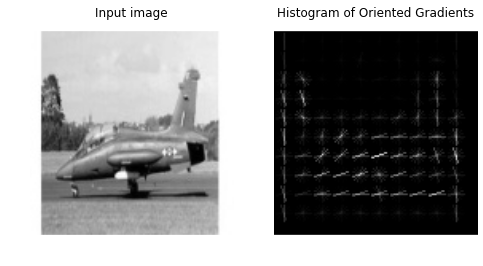

In [34]:
#print(len(extract_features([train_folder+'airplanes_0001.jpg'])))
img_grey = ski.color.rgb2gray(imread(train_folder+'airplanes_0001.jpg'))
fd, hog_image = hog(img_grey, orientations=8, pixels_per_cell=(12, 12),cells_per_block=(9, 9), visualise=True)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4), sharex=True, sharey=True)

ax1.axis('off')
ax1.imshow(img_grey, cmap=plt.cm.gray)
ax1.set_title('Input image')
ax1.set_adjustable('box-forced')

# Rescale histogram for better display
ax2.axis('off')
ax2.imshow(hog_image, cmap=plt.cm.gray)
ax2.set_title('Histogram of Oriented Gradients')
ax1.set_adjustable('box-forced')
plt.show()

In [35]:
features_train = extract_features(image_paths_train)
features_test = extract_features(image_paths_test)

In [36]:
y = np.array([])
X = np.array([])
for img in image_paths_train:
    featurevec = features_train[img]
    if len(X) == 0 :
        X = featurevec
        y =np.array([ymap[img]])
    else:
        X = np.vstack([X, [featurevec]])
        y = np.append(y, [ymap[img]])          


In [37]:
for img in image_paths_test:
    featurevec = features_test[img]
    if len(X) == 0 :
        X = featurevec
        y = np.array([ytmap[img]])
    else:
        X= np.vstack([X, [featurevec]])
        y= np.append(y, [ytmap[img]])


In [26]:
y.size

4244

In [38]:

# save to disk
filename = "./features1.npy"
np.save(filename, X)
print("Saved features to '%s'" % filename)

filename = "./labels1.npy"
np.save(filename, y)
print("Saved categories to '%s'" % filename)

Saved features to './features1.npy'
Saved categories to './labels1.npy'


In [41]:
##
#random forest
from sklearn.cross_validation import cross_val_score
rf = RandomForestClassifier(n_estimators=1000, n_jobs=8,oob_score=True)
scores = cross_val_score(rf, X, y)
scores.mean()


0.29219737714584476

In [42]:
from sklearn.ensemble import ExtraTreesClassifier
rf = ExtraTreesClassifier(n_estimators=500, n_jobs=2,bootstrap = True, oob_score=True)
scores = cross_val_score(rf, X, y)
scores.mean()


0.27616702573800894